## Support Vector Regression

## Importing Libraries

In [1]:
import sys
import os

current_dir = os.getcwd() 
code_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))

if code_dir not in sys.path:
    sys.path.append(code_dir)

from src.models.svm_models import SupportVectorRegression 
from src.loss_functions.regression_losses import EpsilonInsensitiveLoss
from src.optimisers.gradient_based import BatchGradientDescent, StochasticGradientDescent, MiniBatchGradientDescent
from src.optimisers.cellular_automata import CellularAutomataOptimiser

import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Loading the Diabetes Dataset

In [2]:
df_diabetes = pd.read_csv('../datasets/diabetes.csv')
X = df_diabetes.drop("target", axis=1)
y = df_diabetes["target"]

In [3]:
TEST_SIZE = 0.2
SEED = 42

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

n_features = X_train.shape[1]

In [5]:
RUNS = 10
final_aggregated_results = []
PLOTTING_CURVES_EpIL = {}
MAX_ITERS = 1000
ALPHA = 0.01
L=5
MU=0.01
OMEGA=0.8

optimisers = {
    'Batch Gradient Descent': BatchGradientDescent(ALPHA),
    'Stochastic Gradient Descent': StochasticGradientDescent(ALPHA),
    'Mini Batch Gradient Descent': MiniBatchGradientDescent(ALPHA),
    'Cellular Automata Optimiser': CellularAutomataOptimiser(L=L, mu=MU, omega=OMEGA)
}

In [6]:
print('==================== CONFIGURATIONS ====================')
print(f'MAX_ITERS={MAX_ITERS}, TEST_SIZE={TEST_SIZE}, ALPHA={ALPHA}, RUNS={RUNS}')
print(f'L={L}, μ={MU}, ω={OMEGA}')
print('='*56)

# use one optimiser at a time
for optimiser_name, optimiser in optimisers.items():
    # Only one loss function (Epsilon Insensitive Loss) is used for SVR
    loss_name = 'Epsilon Insensitive Loss'

    print('='*75)
    print(f'Running Combination: {optimiser_name} / {loss_name}')

    # metric used for evaluation
    train_losses_for_avg = []
    r2_score_for_avg = []
    test_mse_for_avg = []
    test_mae_for_avg = [] 
    run_times_for_avg = []
    loss_per_iterations = []

    # test every optimiser for 10 runs
    for i in range(RUNS):
        model = SupportVectorRegression(n_features=n_features)

        loss_func = EpsilonInsensitiveLoss(model.C, model.weights, epsilon=0.1)
        
        start_time = time.time()
        optimiser_results = optimiser.optimise(model, loss_func, X_train, y_train, max_iters=MAX_ITERS) 
        run_time = time.time() - start_time

        model.set_params(optimiser_results['parameters'])
        y_pred = model.predict(X_test)

        test_mse = mean_squared_error(y_test, y_pred)
        test_mae = mean_absolute_error(y_test, y_pred)
            
        train_losses_for_avg.append(optimiser_results['best_loss'])
        test_mse_for_avg.append(test_mse)
        test_mae_for_avg.append(test_mae)
        r2_score_for_avg.append(r2_score(y_test, y_pred))
        run_times_for_avg.append(run_time)
        loss_per_iterations.append(optimiser_results['loss_history'])
        
    train_losses_array = np.array(train_losses_for_avg)
    test_mse_array = np.array(test_mse_for_avg)
    test_mae_array = np.array(test_mae_for_avg)
    r2_score_array = np.array(r2_score_for_avg)
    run_times_array = np.array(run_times_for_avg)
    loss_per_iterations_array = np.array(loss_per_iterations)

    avg_train_loss = np.mean(train_losses_array)
    std_dev_train_loss = np.std(train_losses_array)
    avg_test_mse = np.mean(test_mse_array)
    std_dev_test_mse = np.std(test_mse_array)
    avg_test_mae = np.mean(test_mae_array)
    std_dev_test_mae = np.std(test_mae_array)
    avg_r2_score = np.mean(r2_score_array)
    std_dev_r2_score = np.std(r2_score_array)
    avg_time = np.mean(run_times_array)
    std_dev_time = np.std(run_times_array)
    avg_loss_per_iter = np.mean(loss_per_iterations_array, axis=0)
    
    if loss_name == 'Epsilon Insensitive Loss':
        PLOTTING_CURVES_EpIL[optimiser_name] = avg_loss_per_iter
        print(f"-> Stored average {loss_name} curve for {optimiser_name}.")

    final_aggregated_results.append({
        'Optimiser': optimiser_name,
        'Loss_Function': loss_name,
        'Avg_Train_Loss': avg_train_loss,
        'Std_Dev_Train_Loss': std_dev_train_loss,
        'Avg_Test_MSE': avg_test_mse,
        'Std_Dev_Test_MSE': std_dev_test_mse,
        'Avg_Test_MAE': avg_test_mae,
        'Std_Dev_Test_MAE': std_dev_test_mae,
        'Avg_R2_Score': avg_r2_score,
        'Std_Dev_R2_Score': std_dev_r2_score,
        'Avg_Time_s': avg_time,
        'Std_Dev_Time_s': std_dev_time
    })

==================== CONFIGURATIONS ====================
MAX_ITERS=1000, TEST_SIZE=0.2, ALPHA=0.01, RUNS=10
L=5, μ=0.01, ω=0.8
Running Combination: Batch Gradient Descent / Epsilon Insensitive Loss
-> Stored average Epsilon Insensitive Loss curve for Batch Gradient Descent.
Running Combination: Stochastic Gradient Descent / Epsilon Insensitive Loss
-> Stored average Epsilon Insensitive Loss curve for Stochastic Gradient Descent.
Running Combination: Mini Batch Gradient Descent / Epsilon Insensitive Loss
-> Stored average Epsilon Insensitive Loss curve for Mini Batch Gradient Descent.
Running Combination: Cellular Automata Optimiser / Epsilon Insensitive Loss
-> Stored average Epsilon Insensitive Loss curve for Cellular Automata Optimiser.


In [7]:
results_df = pd.DataFrame(final_aggregated_results)

output_folder = "tables"
file_name = "SVR_Diabetes_results_(log scale).csv"
output_path = os.path.join(output_folder, file_name)

results_df.to_csv(output_path, index=False)
print(f"Successfully saved results to: {output_path}")

Successfully saved results to: tables\SVR_Diabetes_results_(log scale).csv


In [8]:
results_df

,Optimiser,Loss_Function,Avg_Train_Loss,Std_Dev_Train_Loss,Avg_Test_MSE,Std_Dev_Test_MSE,Avg_Test_MAE,Std_Dev_Test_MAE,Avg_R2_Score,Std_Dev_R2_Score,Avg_Time_s,Std_Dev_Time_s
0,Batch Gradient Descent,Epsilon Insensitive Loss,28762.899355,5577.717290,10173.016474,3427.953414,81.246850,14.886180,-0.920107,0.647009,0.048611,0.012927
1,Stochastic Gradient Descent,Epsilon Insensitive Loss,86.524037,19.558276,11579.097791,4620.059380,86.798869,18.628586,-1.185498,0.872013,14.295476,0.837250
2,Mini Batch Gradient Descent,Epsilon Insensitive Loss,2798.452936,760.403622,13895.107725,7381.623414,93.006736,24.289087,-1.622633,1.393245,0.556900,0.075363
3,Cellular Automata Optimiser,Epsilon Insensitive Loss,15239.037132,11.140904,3011.045757,62.799905,43.377626,0.477814,0.431680,0.011853,13.189602,1.996774


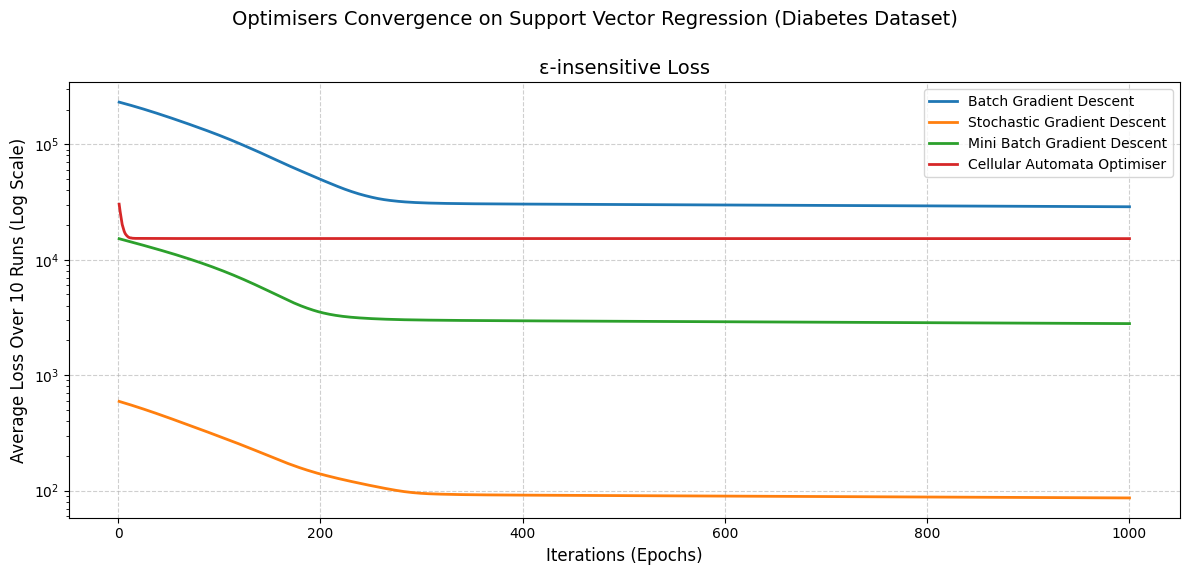

In [9]:
iterations = np.arange(1, MAX_ITERS + 1)
fig, ax = plt.subplots(1, 1, figsize=(12, 6)) 

for optimiser_name, avg_curve in PLOTTING_CURVES_EpIL.items():
    ax.plot(iterations, avg_curve, label=optimiser_name, linewidth=2) 

ax.set_yscale('log')
ax.set_title('ε-insensitive Loss', fontsize=14)
ax.set_xlabel('Iterations (Epochs)', fontsize=12)
ax.set_ylabel('Average Loss Over 10 Runs (Log Scale)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

fig.suptitle('Optimisers Convergence on Support Vector Regression (Diabetes Dataset)', fontsize=14, y=0.95) 
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Log Scale Support Vector Regression Loss Plot (Diabetes Dataset).png')